In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Generate dataset

In [2]:
y = np.random.randint(0,10,5000)
idx= []
for i in range(10):
    print(i,sum(y==i))
    idx.append(y==i)

0 496
1 507
2 491
3 477
4 499
5 517
6 516
7 488
8 487
9 522


In [3]:
x = np.zeros((5000,2))

In [4]:
# x[idx[0],:] = np.random.multivariate_normal(mean = [5,5],cov=[[0.1,0],[0,0.1]],size=sum(idx[0]))

# x[idx[1],:] = np.random.multivariate_normal(mean = [-6,7],cov=[[0.1,0],[0,0.1]],size=sum(idx[1]))

# x[idx[2],:] = np.random.multivariate_normal(mean = [-5,-4],cov=[[0.1,0],[0,0.1]],size=sum(idx[2]))

x[idx[0],:] = np.random.multivariate_normal(mean = [5,5],cov=[[0.1,0],[0,0.1]],size=sum(idx[0]))

x[idx[1],:] = np.random.multivariate_normal(mean = [6,6],cov=[[0.1,0],[0,0.1]],size=sum(idx[1]))

x[idx[2],:] = np.random.multivariate_normal(mean = [5.5,6.5],cov=[[0.1,0],[0,0.1]],size=sum(idx[2]))

x[idx[3],:] = np.random.multivariate_normal(mean = [-1,0],cov=[[0.1,0],[0,0.1]],size=sum(idx[3]))


x[idx[4],:] = np.random.multivariate_normal(mean = [0,2],cov=[[0.1,0],[0,0.1]],size=sum(idx[4]))

x[idx[5],:] = np.random.multivariate_normal(mean = [1,0],cov=[[0.1,0],[0,0.1]],size=sum(idx[5]))

x[idx[6],:] = np.random.multivariate_normal(mean = [0,-1],cov=[[0.1,0],[0,0.1]],size=sum(idx[6]))

x[idx[7],:] = np.random.multivariate_normal(mean = [0,0],cov=[[0.1,0],[0,0.1]],size=sum(idx[7]))

x[idx[8],:] = np.random.multivariate_normal(mean = [-0.5,-0.5],cov=[[0.1,0],[0,0.1]],size=sum(idx[8]))

x[idx[9],:] = np.random.multivariate_normal(mean = [0.4,0.2],cov=[[0.1,0],[0,0.1]],size=sum(idx[9]))

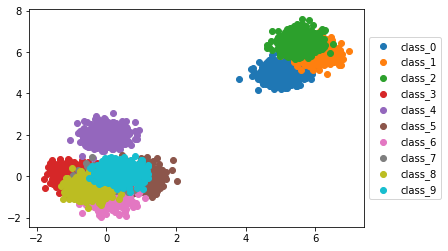

In [5]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [6]:
foreground_classes = {'class_0','class_1', 'class_2'}

background_classes = {'class_3','class_4', 'class_5', 'class_6','class_7', 'class_8', 'class_9'}

In [7]:
fg_class  = np.random.randint(0,3)
fg_idx = np.random.randint(0,9)

a = []
for i in range(9):
    if i == fg_idx:
        b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
        a.append(x[b])
        print("foreground "+str(fg_class)+" present at " + str(fg_idx))
    else:
        bg_class = np.random.randint(3,10)
        b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
        a.append(x[b])
        print("background "+str(bg_class)+" present at " + str(i))
a = np.concatenate(a,axis=0)
print(a.shape)

print(fg_class , fg_idx)

background 3 present at 0
background 5 present at 1
background 8 present at 2
background 6 present at 3
background 5 present at 4
background 4 present at 5
background 8 present at 6
foreground 1 present at 7
background 9 present at 8
(9, 2)
1 7


In [8]:
a.shape

(9, 2)

In [9]:
np.reshape(a,(18,1))

array([[-0.73109471],
       [-0.12644274],
       [ 1.65127131],
       [ 0.03832263],
       [-0.64641853],
       [-0.45220639],
       [-0.16485773],
       [-0.81508331],
       [ 0.70500779],
       [-0.0294793 ],
       [-0.09447456],
       [ 2.19417729],
       [-0.56251095],
       [-0.40235873],
       [ 6.370145  ],
       [ 6.17917332],
       [ 0.47000652],
       [ 0.08380481]])

In [10]:
a=np.reshape(a,(3,6))

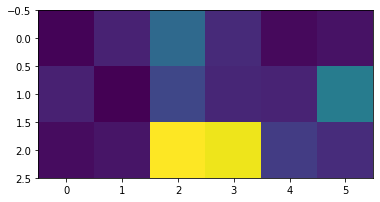

In [11]:
plt.imshow(a)

In [12]:
desired_num = 1000
mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
for j in range(desired_num):
    fg_class  = np.random.randint(0,3)
    fg_idx = 0
    a = []
    for i in range(9):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,10)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(18,1)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

In [13]:
mosaic_list_of_images = np.concatenate(mosaic_list_of_images,axis=1).T
# print(mosaic_list)

In [14]:
print(np.shape(mosaic_list_of_images))
print(np.shape(fore_idx))
print(np.shape(mosaic_label))

(1000, 18)
(1000,)
(1000,)


In [15]:
def create_avg_image_from_mosaic_dataset(mosaic_dataset,labels,foreground_index,dataset_number):
  """
  mosaic_dataset : mosaic_dataset contains 9 images 32 x 32 each as 1 data point
  labels : mosaic_dataset labels
  foreground_index : contains list of indexes where foreground image is present so that using this we can take weighted average
  dataset_number : will help us to tell what ratio of foreground image to be taken. for eg: if it is "j" then fg_image_ratio = j/9 , bg_image_ratio = (9-j)/8*9
  """
  avg_image_dataset = []
  cnt = 0
  counter = np.array([0,0,0,0,0,0,0,0,0])
  for i in range(len(mosaic_dataset)):
    img = torch.zeros([18], dtype=torch.float64)
    np.random.seed(dataset_number*10000 + i)
    give_pref = foreground_index[i] #np.random.randint(0,9)
    # print("outside", give_pref,foreground_index[i])
    for j in range(9):
      if j == give_pref:
        img = img + mosaic_dataset[i][j]*dataset_number/9
      else :
        img = img + mosaic_dataset[i][j]*(9-dataset_number)/(8*9)

    if give_pref == foreground_index[i] :
      # print("equal are", give_pref,foreground_index[i])
      cnt += 1
      counter[give_pref] += 1
    else :
      counter[give_pref] += 1

    avg_image_dataset.append(img)

  print("number of correct averaging happened for dataset "+str(dataset_number)+" is "+str(cnt)) 
  print("the averaging are done as ", counter) 
  return avg_image_dataset , labels , foreground_index
        
  

In [16]:
avg_image_dataset_1 , labels_1,  fg_index_1 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images, mosaic_label, fore_idx, 1)
avg_image_dataset_2 , labels_2,  fg_index_2 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images, mosaic_label, fore_idx, 2)
avg_image_dataset_3 , labels_3,  fg_index_3 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images, mosaic_label, fore_idx , 3)
avg_image_dataset_4 , labels_4,  fg_index_4 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images, mosaic_label, fore_idx , 4)
avg_image_dataset_5 , labels_5,  fg_index_5 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images, mosaic_label, fore_idx , 5)
avg_image_dataset_6 , labels_6,  fg_index_6 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images, mosaic_label, fore_idx , 6)
avg_image_dataset_7 , labels_7,  fg_index_7 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images, mosaic_label, fore_idx , 7)
avg_image_dataset_8 , labels_8,  fg_index_8 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images, mosaic_label, fore_idx , 8)
avg_image_dataset_9 , labels_9,  fg_index_9 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images, mosaic_label, fore_idx, 9)



number of correct averaging happened for dataset 1 is 1000
the averaging are done as  [1000    0    0    0    0    0    0    0    0]
number of correct averaging happened for dataset 2 is 1000
the averaging are done as  [1000    0    0    0    0    0    0    0    0]
number of correct averaging happened for dataset 3 is 1000
the averaging are done as  [1000    0    0    0    0    0    0    0    0]
number of correct averaging happened for dataset 4 is 1000
the averaging are done as  [1000    0    0    0    0    0    0    0    0]
number of correct averaging happened for dataset 5 is 1000
the averaging are done as  [1000    0    0    0    0    0    0    0    0]
number of correct averaging happened for dataset 6 is 1000
the averaging are done as  [1000    0    0    0    0    0    0    0    0]
number of correct averaging happened for dataset 7 is 1000
the averaging are done as  [1000    0    0    0    0    0    0    0    0]
number of correct averaging happened for dataset 8 is 1000
the averag

In [17]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    #self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] #, self.fore_idx[idx]



In [18]:
batch = 200
epochs = 300

# training_data = avg_image_dataset_5    #just change this and training_label to desired dataset for training
# training_label = labels_5

traindata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
trainloader_1 = DataLoader( traindata_1 , batch_size= batch ,shuffle=True)

traindata_2 = MosaicDataset(avg_image_dataset_2, labels_2 )
trainloader_2 = DataLoader( traindata_2 , batch_size= batch ,shuffle=True)

traindata_3 = MosaicDataset(avg_image_dataset_3, labels_3 )
trainloader_3 = DataLoader( traindata_3 , batch_size= batch ,shuffle=True)

traindata_4 = MosaicDataset(avg_image_dataset_4, labels_4 )
trainloader_4 = DataLoader( traindata_4 , batch_size= batch ,shuffle=True)

traindata_5 = MosaicDataset(avg_image_dataset_5, labels_5 )
trainloader_5 = DataLoader( traindata_5 , batch_size= batch ,shuffle=True)

traindata_6 = MosaicDataset(avg_image_dataset_6, labels_6 )
trainloader_6 = DataLoader( traindata_6 , batch_size= batch ,shuffle=True)

traindata_7 = MosaicDataset(avg_image_dataset_7, labels_7 )
trainloader_7 = DataLoader( traindata_7 , batch_size= batch ,shuffle=True)

traindata_8 = MosaicDataset(avg_image_dataset_8, labels_8 )
trainloader_8 = DataLoader( traindata_8 , batch_size= batch ,shuffle=True)

traindata_9 = MosaicDataset(avg_image_dataset_9, labels_9 )
trainloader_9 = DataLoader( traindata_9 , batch_size= batch ,shuffle=True)

testdata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
testloader_1 = DataLoader( testdata_1 , batch_size= batch ,shuffle=False)

testdata_2 = MosaicDataset(avg_image_dataset_2, labels_2 )
testloader_2 = DataLoader( testdata_2 , batch_size= batch ,shuffle=False)

testdata_3 = MosaicDataset(avg_image_dataset_3, labels_3 )
testloader_3 = DataLoader( testdata_3 , batch_size= batch ,shuffle=False)

testdata_4 = MosaicDataset(avg_image_dataset_4, labels_4 )
testloader_4 = DataLoader( testdata_4 , batch_size= batch ,shuffle=False)

testdata_5 = MosaicDataset(avg_image_dataset_5, labels_5 )
testloader_5 = DataLoader( testdata_5 , batch_size= batch ,shuffle=False)

testdata_6 = MosaicDataset(avg_image_dataset_6, labels_6 )
testloader_6 = DataLoader( testdata_6 , batch_size= batch ,shuffle=False)

testdata_7 = MosaicDataset(avg_image_dataset_7, labels_7 )
testloader_7 = DataLoader( testdata_7 , batch_size= batch ,shuffle=False)

testdata_8 = MosaicDataset(avg_image_dataset_8, labels_8 )
testloader_8 = DataLoader( testdata_8 , batch_size= batch ,shuffle=False)

testdata_9 = MosaicDataset(avg_image_dataset_9, labels_9 )
testloader_9 = DataLoader( testdata_9 , batch_size= batch ,shuffle=False)

In [19]:
class Wherenet(nn.Module):
    def __init__(self):
        super(Wherenet,self).__init__()
        self.linear1 = nn.Linear(2,128)
        self.linear2 = nn.Linear(128,256)
        self.linear3 = nn.Linear(256,128)
        self.linear4 = nn.Linear(128,64)
        self.linear5 = nn.Linear(64,1)
    def forward(self,z):
        x = torch.zeros([batch,9],dtype=torch.float64)
        y = torch.zeros([batch,2], dtype=torch.float64)
        #x,y = x.to("cuda"),y.to("cuda")
        for i in range(9):
            x[:,i] = self.helper(z[:,2*i:2*i+2])[:,0]
            #print(k[:,0].shape,x[:,i].shape)
        x = F.softmax(x,dim=1)   # alphas
        x1 = x[:,0]
        for i in range(9):
            x1 = x[:,i]          
            #print()
            y = y+torch.mul(x1[:,None],z[:,2*i:2*i+2])
        return y , x 

    
    def helper(self,x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))
        x = self.linear5(x)
        return x

    

In [20]:
trainiter = iter(trainloader_1)
input1,labels1 = trainiter.next()

input1.shape

torch.Size([200, 18])

In [21]:
where = Wherenet().double()
where = where
out_where,alphas = where(input1)
out_where.shape,alphas.shape

(torch.Size([200, 2]), torch.Size([200, 9]))

In [22]:
class Whatnet(nn.Module):
    def __init__(self):
        super(Whatnet,self).__init__()
        self.linear1 = nn.Linear(2,128)
        self.linear2 = nn.Linear(128,256)
        self.linear3 = nn.Linear(256,128)
        self.linear4 = nn.Linear(128,64)
        self.linear5 = nn.Linear(64,3)
    def forward(self,x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))
        x = self.linear5(x)
        return x

In [23]:
# what = Whatnet().double()
# what(out_where)

In [24]:
def test_all(number, testloader,what, where):
    correct = 0
    total = 0
    out = []
    pred = []
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            # images, labels = images.to("cuda"),labels.to("cuda")
            out.append(labels.cpu().numpy())
            avg_inp,alphas = where(inputs)        
            outputs = what(avg_inp)
            _, predicted = torch.max(outputs.data, 1)
            pred.append(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test dataset %d: %d %%' % (number , 100 * correct / total))

In [35]:
def train_all(trainloader, ds_number, testloader_list):
    
    print("--"*40)
    print("training on data set  ", ds_number)
    
    where = Wherenet().double()
    what = Whatnet().double()
    criterion = nn.CrossEntropyLoss()
    # optimizer_where = optim.SGD(where.parameters(), lr=0.001, momentum=0.9)
    optimizer_where = optim.Adam(where.parameters(), lr=1e-2, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=True)
    # optimizer_what = optim.SGD(what.parameters(), lr=0.001, momentum=0.9)
    optimizer_what = optim.Adam(what.parameters(), lr=1e-2, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=True)
    
    acti = []
    loss_curi = []
    epochs = 500
    
    for epoch in range(epochs): # loop over the dataset multiple times
        ep_lossi = []

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            # inputs, labels = inputs.to("cuda"),labels.to("cuda")

            # zero the parameter gradients
            optimizer_what.zero_grad()
            optimizer_where.zero_grad()

            # forward + backward + optimize
            avg_inp,alphas = where(inputs) 
            # print(avg_inp.shape)       
            outputs = what(avg_inp)
            

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer_what.step()
            optimizer_where.step()

            # print statistics
            running_loss += loss.item()
            mini = 4
            if i % mini == mini-1:    # print every 10 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / mini))
                ep_lossi.append(running_loss/mini) # loss per minibatch
                running_loss = 0.0
                
        loss_curi.append(np.mean(ep_lossi))   #loss per epoch
        if (np.mean(ep_lossi) <= 0.05):
            break


    print('Finished Training')
    # torch.save(inc.state_dict(),"train_dataset_"+str(ds_number)+"_"+str(epochs)+".pt")
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            inputs, labels = data
            # images, labels = images.to("cuda"), labels.to("cuda")
            avg_inp,alphas = where(inputs)        
            outputs = what(avg_inp)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 train images: %d %%' % (  100 * correct / total))
    
    for i, j in enumerate(testloader_list):
        test_all(i+1, j,what, where)
    
    print("--"*40)
    
    return loss_curi
    

In [36]:
train_loss_all=[]

testloader_list= [ testloader_1, testloader_2, testloader_3, testloader_4, testloader_5, testloader_6,
                 testloader_7, testloader_8, testloader_9]

In [37]:
train_loss_all.append(train_all(trainloader_1, 1, testloader_list))
train_loss_all.append(train_all(trainloader_2, 2, testloader_list))
train_loss_all.append(train_all(trainloader_3, 3, testloader_list))
train_loss_all.append(train_all(trainloader_4, 4, testloader_list))
train_loss_all.append(train_all(trainloader_5, 5, testloader_list))
train_loss_all.append(train_all(trainloader_6, 6, testloader_list))
train_loss_all.append(train_all(trainloader_7, 7, testloader_list))
train_loss_all.append(train_all(trainloader_8, 8, testloader_list))
train_loss_all.append(train_all(trainloader_9, 9, testloader_list))

--------------------------------------------------------------------------------
training on data set   1
[1,     4] loss: 1.111
[2,     4] loss: 1.073
[3,     4] loss: 1.047
[4,     4] loss: 1.043
[5,     4] loss: 1.046
[6,     4] loss: 1.040
[7,     4] loss: 1.036
[8,     4] loss: 1.036
[9,     4] loss: 1.029
[10,     4] loss: 1.038
[11,     4] loss: 1.028
[12,     4] loss: 1.032
[13,     4] loss: 1.027
[14,     4] loss: 1.034
[15,     4] loss: 1.040
[16,     4] loss: 1.036
[17,     4] loss: 1.021
[18,     4] loss: 1.032
[19,     4] loss: 1.049
[20,     4] loss: 1.022
[21,     4] loss: 1.027
[22,     4] loss: 1.030
[23,     4] loss: 1.033
[24,     4] loss: 1.039
[25,     4] loss: 1.024
[26,     4] loss: 1.035
[27,     4] loss: 1.028
[28,     4] loss: 1.032
[29,     4] loss: 1.026
[30,     4] loss: 1.031
[31,     4] loss: 1.038
[32,     4] loss: 1.026
[33,     4] loss: 1.034
[34,     4] loss: 1.025
[35,     4] loss: 1.030
[36,     4] loss: 1.030
[37,     4] loss: 1.034
[38,     4] los

In [38]:
%matplotlib inline

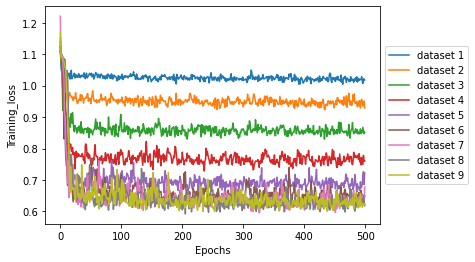

In [39]:
for i,j in enumerate(train_loss_all):
    plt.plot(j,label ="dataset "+str(i+1))
    

plt.xlabel("Epochs")
plt.ylabel("Training_loss")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))